In [4]:
import torch
import sys
import os
import json
import numpy as np

sys.path.append("..")
from singleVis.SingleVisualizationModel import VisModel
from singleVis.data import NormalDataProvider
from singleVis.projector import TimeVisProjector

In [5]:
VIS_METHOD = "TimeVis" 

In [6]:
CONTENT_PATH ="/home/xianglin/data/resnet18_CIFAR10"
GPU_ID = "0"

In [7]:
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

In [8]:
SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
# GPU_ID = config["GPU"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]
EPOCH_NAME = config["EPOCH_NAME"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]

VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, epoch_name=EPOCH_NAME, device=DEVICE, classes=CLASSES,verbose=1)

Finish initialization...


In [9]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)

In [10]:
import json
with open(f"{CONTENT_PATH}/noisy_label.json", "r") as f: 
    noise_labels = np.array(json.load(f))
with open(f"{CONTENT_PATH}/clean_label.json", "r") as f: 
    clean_labels = np.array(json.load(f))

idxs = np.argwhere(noise_labels!=clean_labels).squeeze()

In [11]:
from singleVis.training_dynamics import TD
td = TD(data_provider, projector)

100%|██████████| 300/300 [00:00<00:00, 437.49it/s]


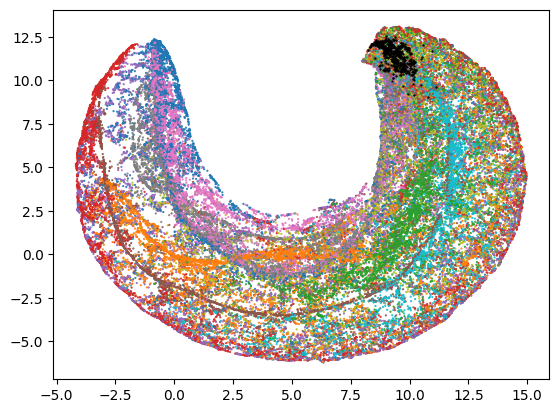

In [9]:
losses = td.loss_dynamics()
td.show_ground_truth(losses, idxs)

100%|██████████| 250/250 [00:00<00:00, 424.38it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


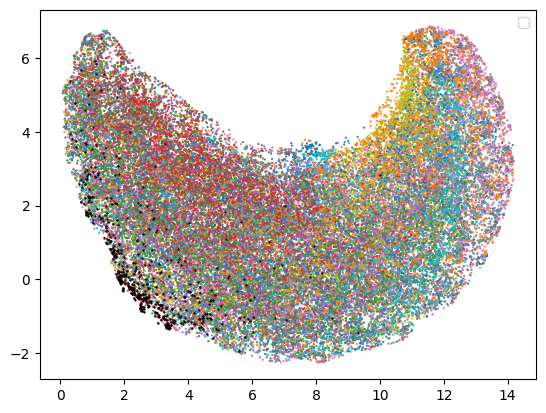

In [12]:
# cifar10
losses = td.loss_dynamics()
td.show_ground_truth(losses, idxs)

100%|██████████| 300/300 [00:00<00:00, 432.68it/s]


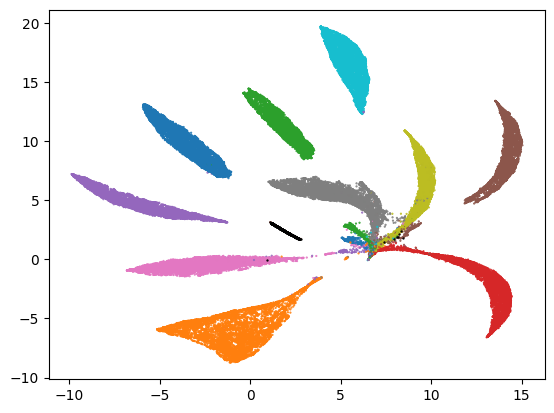

In [10]:
uncertainties = td.uncertainty_dynamics()
td.show_ground_truth(uncertainties, idxs);

100%|██████████| 250/250 [00:00<00:00, 449.36it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


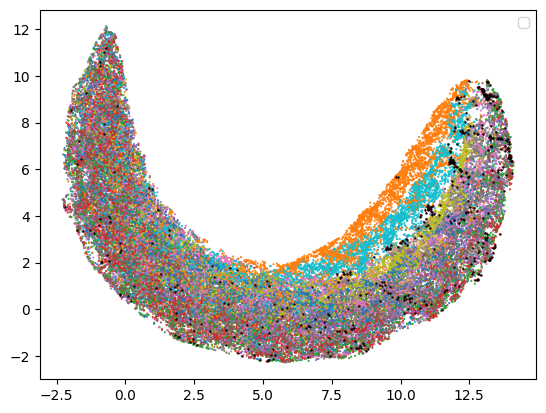

In [13]:
# cifar10
uncertainties = td.uncertainty_dynamics()
td.show_ground_truth(uncertainties, idxs);

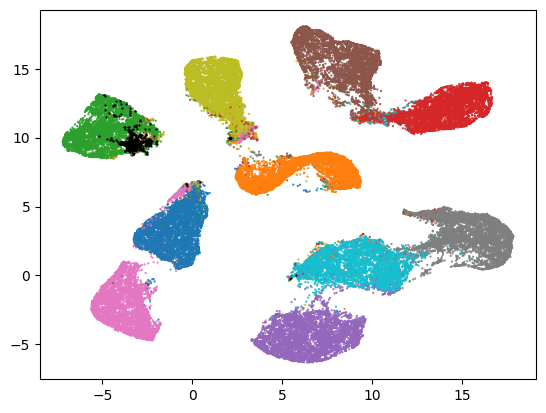

In [10]:
positions = td.position_dynamics()
td.show_ground_truth(positions, idxs);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


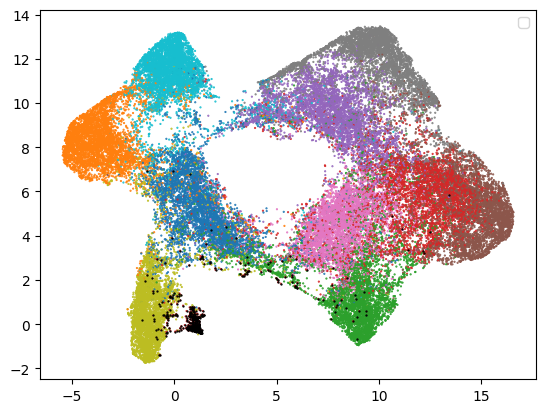

In [14]:
# cifar10
positions = td.position_dynamics()
td.show_ground_truth(positions, idxs);

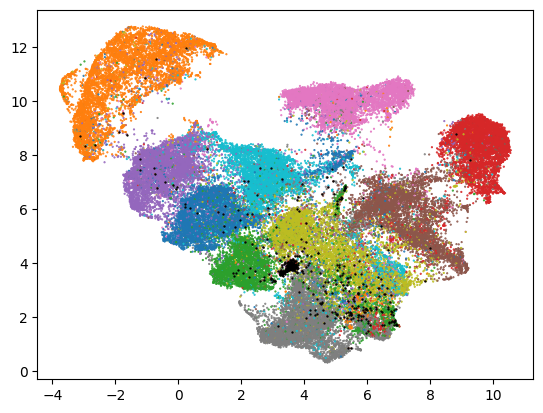

In [11]:
velocity = td.velocity_dynamics()
td.show_ground_truth(velocity, idxs);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


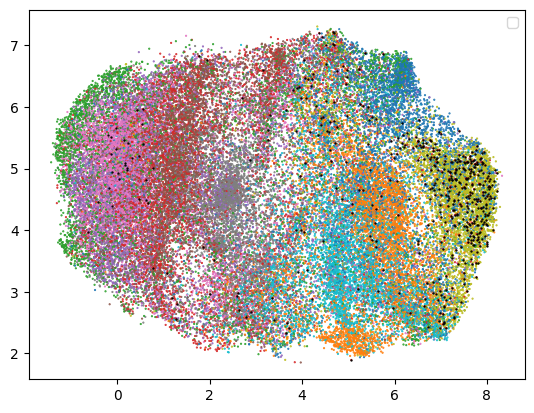

In [16]:
# cigar0
velocity = td.velocity_dynamics()
td.show_ground_truth(velocity, idxs);

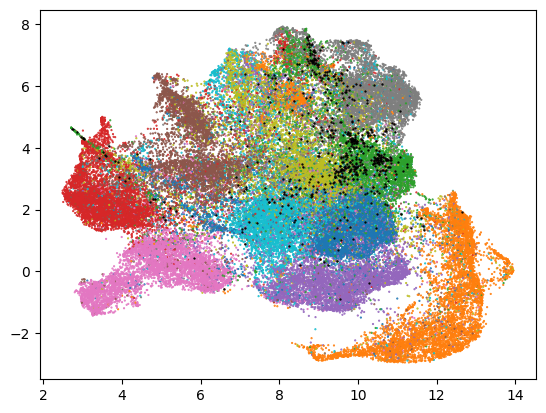

In [12]:
acceleration = td.acceleration_dynamics()
td.show_ground_truth(acceleration, idxs);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


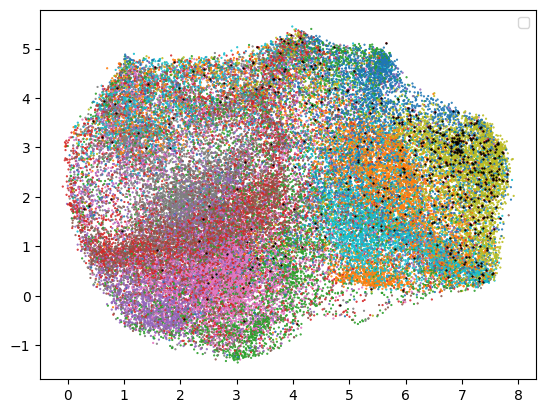

: 

In [17]:
# cifar 10
acceleration = td.acceleration_dynamics()
td.show_ground_truth(acceleration, idxs);

100%|██████████| 300/300 [00:00<00:00, 440.06it/s]


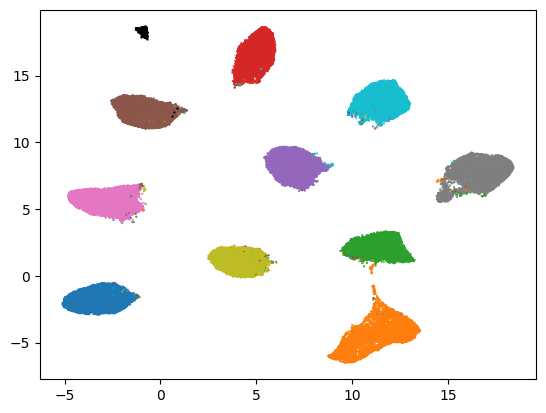

In [9]:
pred = td.pred_dynamics()
td.show_ground_truth(pred, idxs)

100%|██████████| 250/250 [00:00<00:00, 445.78it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


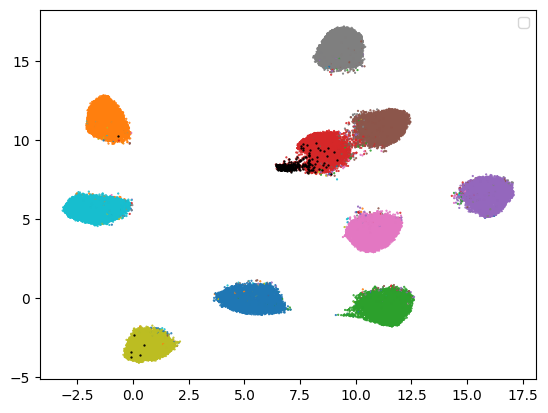

In [15]:
# cifar10
pred = td.pred_dynamics()
td.show_ground_truth(pred, idxs)